# 개요
- 출처
  - 원본 데이터 셋
    - [Stroke Prediction Dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset)
  - 경진 대회 데이터 셋
    - [Paris Housing Price](https://www.kaggle.com/competitions/playground-series-s3e6/overview) 
- 개요 
  - 세계보건기구(WHO)에 따르면 뇌졸중은 전체 사망자의 약 11%를 차지하는 세계 2위의 사망 원인이다. 
  - 이 데이터 세트는 성별, 나이, 다양한 질병 및 흡연 상태와 같은 입력 매개 변수를 기반으로 환자가 뇌졸중에 걸릴 가능성이 있는지 예측 
  - 각 행은 환자에 대한 관련 정보를 제공한다.
- 평가지표 : ROC Curve
- 타임라인 : 2023.1.10 ~ 2023.1.16

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve
from scipy import sparse
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [6]:
# 데이터 가져오기 
data_path = '/content/drive/MyDrive/cloud_ai/2차_실기평가/2차_모듈/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id') 
origin = pd.read_csv(data_path + 'healthcare-dataset-stroke-data.csv', index_col='id')

origin.shape, train.shape, test.shape, submission.shape

((5110, 11), (15304, 11), (10204, 10), (10204, 1))

In [7]:
# original train, test, submission 열 확인
origin.columns, train.columns, test.columns, submission.columns

(Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status', 'stroke'],
       dtype='object'),
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status', 'stroke'],
       dtype='object'),
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status'],
       dtype='object'),
 Index(['stroke'], dtype='object'))

```
< 각 열에 대한 정보 확인 >

'id', : 고유 ID -> 확인 결과 id 컬럼은 인덱스와 같은 의미
'gender', : Male, Female, other로 구성됨 -> 범주형(명목형)
'age', : 나이 / 수치형
'hypertension',  : 고혈압 유무 / 0 : 무, 1 : 유 => 범주형(이진형)
'heart_disease', : 심장질환 유무 / 0 : 무, 1 : 유 => 범주형(이진형)
'ever_married', : 결혼 유무 / Y : 기혼, N : 미혼 => 범주형(이진형)
'work_type', : 업무형태 / 'Private', 'children', 'Govt_job', 'Self-employed', 'Never_worked' => 범주형(명목형)
'Residence_type', : 거주지 유형 /  Urban, Rural / 도시, 시골 => 범주형(이진)
'avg_glucose_level', 평균 당 수치 / 수치형 
'bmi', : 비만도 / 수치형
'smoking_status', : 흡연상태  / 'never smoked', 'formerly smoked', 'Unknown', 'smokes' => 범주형(명목형)
'stroke' : 뇌졸중 유무 / 0 : 무, 1 : 유  => 정답(target)

```






In [8]:
train

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0
...,...,...,...,...,...,...,...,...,...,...,...
15299,Female,22.0,0,0,No,Govt_job,Urban,72.63,19.5,never smoked,0
15300,Female,46.0,1,0,Yes,Private,Urban,101.19,32.1,never smoked,0
15301,Female,75.0,0,0,Yes,Self-employed,Urban,87.69,26.2,never smoked,0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [10]:
test

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
id,,,,,,,,,,
15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes
...,...,...,...,...,...,...,...,...,...,...
25503,Female,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked
25504,Male,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown
25505,Female,3.0,0,0,No,children,Rural,104.04,18.3,Unknown


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10204 entries, 15304 to 25507
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             10204 non-null  object 
 1   age                10204 non-null  float64
 2   hypertension       10204 non-null  int64  
 3   heart_disease      10204 non-null  int64  
 4   ever_married       10204 non-null  object 
 5   work_type          10204 non-null  object 
 6   Residence_type     10204 non-null  object 
 7   avg_glucose_level  10204 non-null  float64
 8   bmi                10204 non-null  float64
 9   smoking_status     10204 non-null  object 
dtypes: float64(3), int64(2), object(5)
memory usage: 876.9+ KB


In [12]:
origin

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...
18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0


In [13]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [14]:
submission

,stroke
id,
15304,0.041296
15305,0.041296
15306,0.041296
15307,0.041296
15308,0.041296
...,...
25503,0.041296
25504,0.041296
25505,0.041296


# 초기 파악



## 결측치 확인

In [15]:
# original 결측값 확인됨
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 비율로 확인
def null_per(df):
    return (df.isnull().sum() / len(df)*100).sort_values(ascending=False)

plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Original Dataset", "Training Dataset","Test Dataset"))

null_per_origin = null_per(origin)
null_per_train = null_per(train)
null_per_test = null_per(test)

print(null_per_origin)
fig.add_trace(
    go.Bar(x=null_per_origin.index, y=null_per_origin.values),
    row=1, col=1
)

print(null_per_train)

fig.add_trace(
    go.Bar(x=null_per_train.index, y=null_per_train.values),
    row=1, col=2
)

print(null_per_test)

fig.add_trace(
    go.Bar(x=null_per_test.index, y=null_per_test.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# null값 비율 확인 시 original 데이터의 bmi열에서 결측치가 존재 -> 제거 or 중간값, 평균값으로 대체 필요

bmi                  3.933464
gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
smoking_status       0.000000
stroke               0.000000
dtype: float64
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
dtype: float64


<Figure size 432x288 with 0 Axes>

## 고유값 확인

In [16]:
plt.tight_layout() # 여백 확보

fig = make_subplots(rows=1, cols=3,
                    subplot_titles=("Unique values For Original Dataset", "For Training Dataset","For Test Dataset"))

temp_data= origin.nunique().sort_values()
print(temp_data)
fig.add_trace(
    go.Bar(x=temp_data.index, y=temp_data.values),
    row=1, col=1
)

temp2_data= train.nunique().sort_values()
print(temp2_data)

fig.add_trace(
    go.Bar(x=temp2_data.index, y=temp2_data.values),
    row=1, col=2
)

temp3_data= test.nunique().sort_values()
print(temp3_data)

fig.add_trace(
    go.Bar(x=temp3_data.index, y=temp3_data.values),
    row=1, col=3
)

fig.update_layout(height=400)
fig.show()

# 이진형 : hypertension, heart_disease, ever_married, Residence_type, stroke
# 범주형 : gender, smoking_status, work_type
# 수치형 : age, bmi, avg_glucose_level 

hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
gender                  3
smoking_status          4
work_type               5
age                   104
bmi                   418
avg_glucose_level    3979
dtype: int64
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
stroke                  2
gender                  3
smoking_status          4
work_type               5
age                   106
bmi                   407
avg_glucose_level    3740
dtype: int64
hypertension            2
heart_disease           2
ever_married            2
Residence_type          2
gender                  3
smoking_status          4
work_type               5
age                   106
bmi                   400
avg_glucose_level    3265
dtype: int64


<Figure size 432x288 with 0 Axes>

## 중복값 확인

In [17]:
train.shape, train.drop_duplicates().shape

((15304, 11), (15304, 11))

In [18]:
test.shape, test.drop_duplicates().shape

((10204, 10), (10204, 10))

In [19]:
origin.shape, origin.drop_duplicates().shape

((5110, 11), (5110, 11))

## 전체 요약

In [20]:
def summary(df):
    print(f'data shape: {df.shape}')
    sum_df = pd.DataFrame(df.dtypes, columns=['type'])
    sum_df['null'] = df.isnull().sum().values * 100
    #sum_df['missing_per'] = df.isnull().sum().values / len(df)
    sum_df['unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    sum_df['min'] = desc['min'].values
    sum_df['max'] = desc['max'].values
    sum_df['mean'] = desc['mean'].values
    sum_df['first value'] = df.iloc[0].values
    sum_df['second value'] = df.iloc[1].values
    sum_df['third value'] = df.iloc[2].values
    
    return sum_df
    
summary_df = summary(train)
summary_df

data shape: (15304, 11)


,type,null,unique,min,max,mean,first value,second value,third value
gender,object,0,3,NaN,NaN,NaN,Male,Male,Female
age,float64,0,106,0.08,82.0,41.417708,28.0,33.0,42.0
hypertension,int64,0,2,0.0,1.0,0.049726,0,0,0
heart_disease,int64,0,2,0.0,1.0,0.023327,0,0,0
ever_married,object,0,2,NaN,NaN,NaN,Yes,Yes,Yes
work_type,object,0,5,NaN,NaN,NaN,Private,Private,Private
Residence_type,object,0,2,NaN,NaN,NaN,Urban,Rural,Rural
avg_glucose_level,float64,0,3740,55.22,267.6,89.039853,79.53,78.44,103.0
bmi,float64,0,407,10.3,80.1,28.112721,31.1,23.9,40.3
smoking_status,object,0,4,NaN,NaN,NaN,never smoked,formerly smoked,Unknown


In [21]:
summary_df2 = summary(origin)
summary_df2

data shape: (5110, 11)


,type,null,unique,min,max,mean,first value,second value,third value
gender,object,0,3,NaN,NaN,NaN,Male,Female,Male
age,float64,0,104,0.08,82.0,43.226614,67.0,61.0,80.0
hypertension,int64,0,2,0.0,1.0,0.097456,0,0,0
heart_disease,int64,0,2,0.0,1.0,0.054012,1,0,1
ever_married,object,0,2,NaN,NaN,NaN,Yes,Yes,Yes
work_type,object,0,5,NaN,NaN,NaN,Private,Self-employed,Private
Residence_type,object,0,2,NaN,NaN,NaN,Urban,Rural,Rural
avg_glucose_level,float64,0,3979,55.12,271.74,106.147677,228.69,202.21,105.92
bmi,float64,20100,418,10.3,97.6,28.893237,36.6,NaN,32.5
smoking_status,object,0,4,NaN,NaN,NaN,formerly smoked,never smoked,never smoked


In [22]:
summary_df3 = summary(test)
summary_df3

data shape: (10204, 10)


,type,null,unique,min,max,mean,first value,second value,third value
gender,object,0,3,NaN,NaN,NaN,Female,Male,Female
age,float64,0,106,0.08,82.0,41.920713,57.0,70.0,5.0
hypertension,int64,0,2,0.0,1.0,0.05145,0,1,0
heart_disease,int64,0,2,0.0,1.0,0.021756,0,0,0
ever_married,object,0,2,NaN,NaN,NaN,Yes,Yes,No
work_type,object,0,5,NaN,NaN,NaN,Private,Private,children
Residence_type,object,0,2,NaN,NaN,NaN,Rural,Urban,Urban
avg_glucose_level,float64,0,3265,55.12,267.6,89.197766,82.54,72.06,103.72
bmi,float64,0,400,11.5,97.6,28.242351,33.4,28.5,19.5
smoking_status,object,0,4,NaN,NaN,NaN,Unknown,Unknown,Unknown


# EDA

## Target 분포 확인

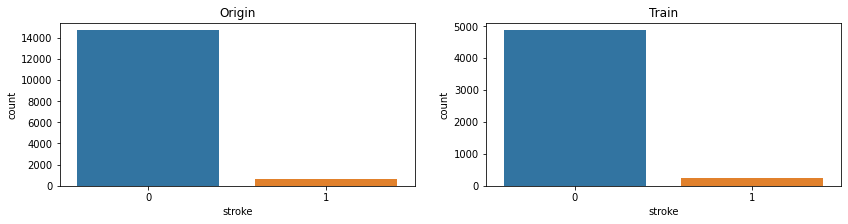

In [23]:
plt.figure(figsize=(14,3))
ax1 = plt.subplot(1,2,1)
sns.countplot(data=train, x='stroke');
plt.title('Origin')
ax2 = plt.subplot(1,2,2)
sns.countplot(data=origin, x='stroke');
plt.title('Train')
plt.show()
# 뇌졸중을 가진 사람보다 뇌졸중이 아닌 사람이 훨씬 많음 -> 데이터 불균형함 -> train/test 시 startify = y 설정 또는 startify-fold로 모델 평가 진행

## 피처 요약 기준 해석 및 전략 수립

- 수치형
  - age
  - avg_glucose_level
  - bmi


In [24]:
# 수치형, 범주형, 명목형 분류

# 수치형
num_cols = ['age', 'avg_glucose_level', 'bmi'] 

# 범주형
cat_cols = ['gender', 'hypertension','heart_disease','ever_married','work_type', 'Residence_type', 'smoking_status'] 

# 명목형을 고유값 개수에 따라 세부 분류함
cat_cols_v0 = ['gender'] # gender만 따로 진행한 이유는 male, female, other로 고유값 3개로 확인되어 따로 지정해둠 
cat_cols_v1 = ['hypertension','heart_disease', 'Residence_type', 'ever_married']
cat_cols_v2 = ['work_type', 'smoking_status']

In [25]:
# 범주형 변수의 고유값 수
print(pd.unique(train["gender"]))
print(pd.unique(train["smoking_status"]))
print(pd.unique(train["ever_married"]))
print(pd.unique(train["work_type"]))
print(pd.unique(train["Residence_type"]))

['Male' 'Female' 'Other']
['never smoked' 'formerly smoked' 'Unknown' 'smokes']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']


### histplot

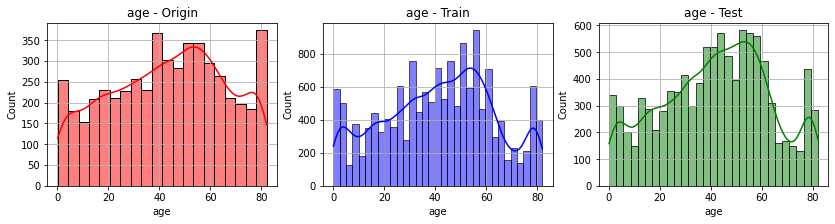

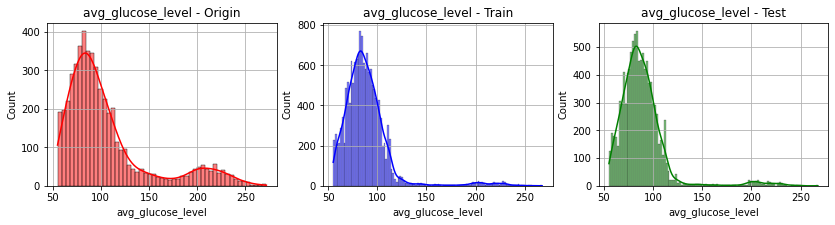

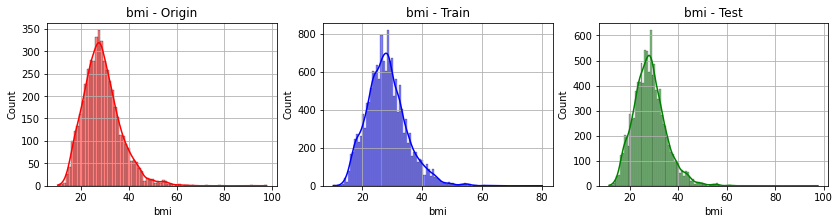

In [26]:
for f in num_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.histplot(x=origin[f], color='r', kde=True)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.histplot(x=train[f], color='b', kde=True)
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.histplot(x=test[f],color='g', kde=True)
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

### Boxplot

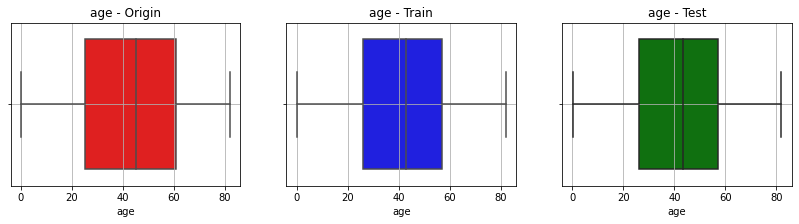

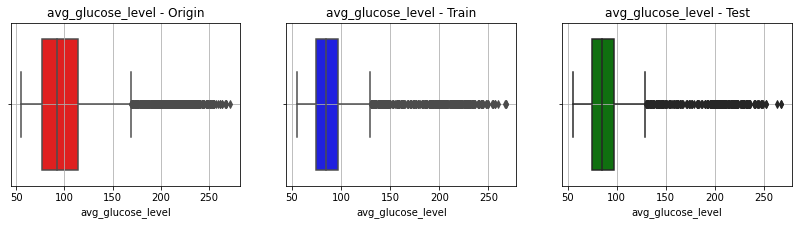

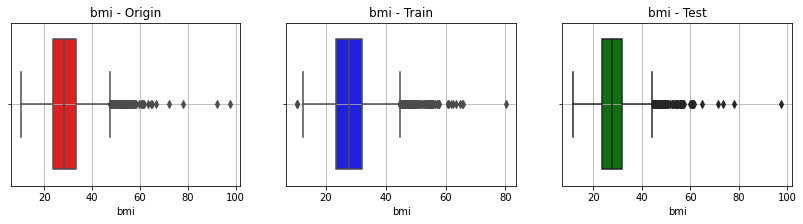

In [27]:
for f in num_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.boxplot(x=origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.boxplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.boxplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show()

# 나이는 일반적으로 20세에서 60세 사이의 연령 분포에 속함
# BMI, 당 수치는 정상인 것 같지만 수치가 높음
# avg_lucose_level이 정상인 것처럼 보이기 때문에, 우리가 볼 수 있듯이 더 높은 값이 있다
# Bmi에는 40이상의 높은 수치가 있는데, 이는 40이상의 수치를 가진 사람들이 높은 비만 위험을 짊어질 수 있다는 것을 의미한다
# -> 그러므로, 이상치로 보기가 쉽지 않음

### Countplot

- 이진형
  - hypertension
  - heart_disease
  - Residence_type
  - ever_married
- 고유값 2개 초과
  - gender
  - work_type
  - smoking_status

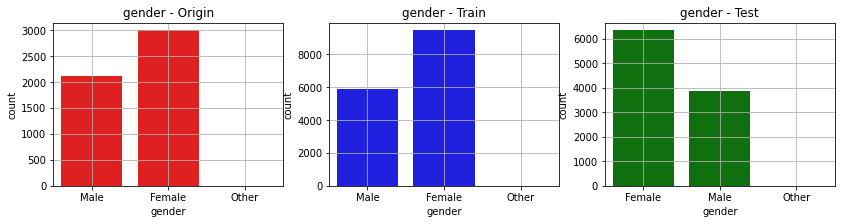

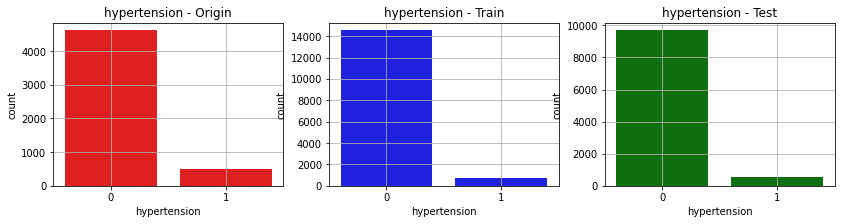

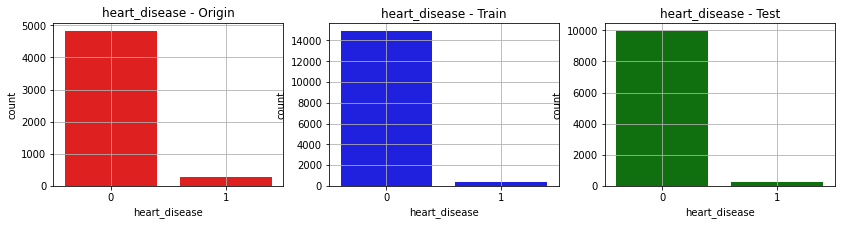

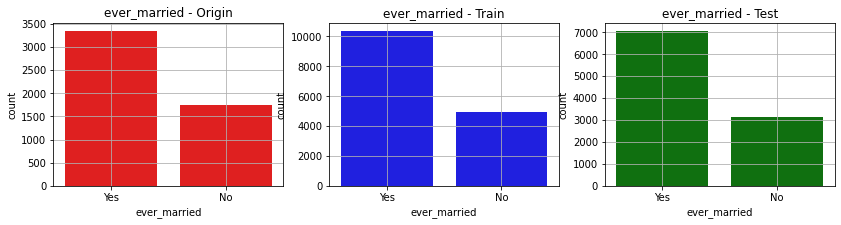

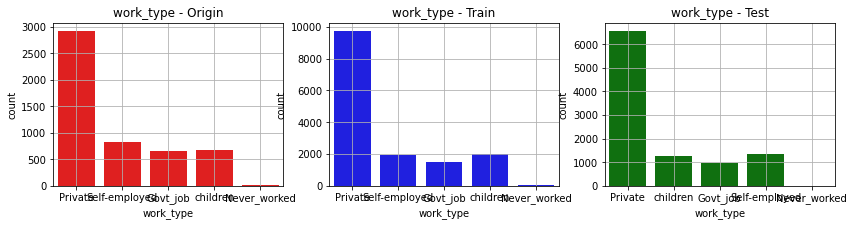

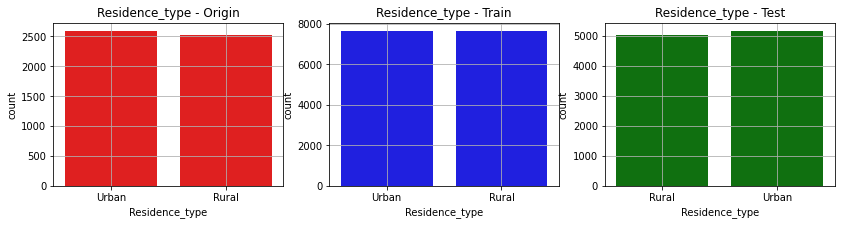

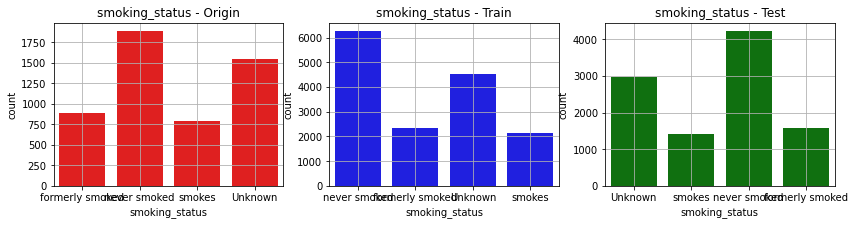

In [28]:
for f in cat_cols:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,3,1)
  sns.countplot(x= origin[f], color='r')
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,3,2)
  sns.countplot(x=train[f], color='b')
  plt.title(f + ' - Train')
  plt.grid()
  ax3 = plt.subplot(1,3,3)
  sns.countplot(x=test[f],color='g')
  plt.title(f + ' - Test')
  plt.grid()
  plt.show() 

# Gender는 여성이 좀 더 많음
# 고혈압, 심장병 여부는 뇌졸증(target)가 비율이 유사
# 거주지 타입의 비율을 거의 동일
# 작업 유형은 민간 직업이 많음

#### Gender

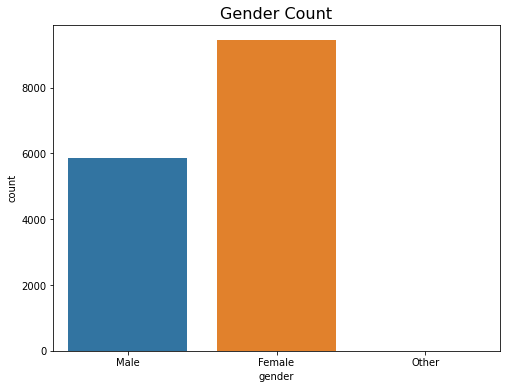

In [29]:
# gender의 개수 시각화  -> 남성보다 여성 분포가 많이 보임
plt.figure(figsize=(8, 6))

ax = sns.countplot(x = 'gender', data = train)
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

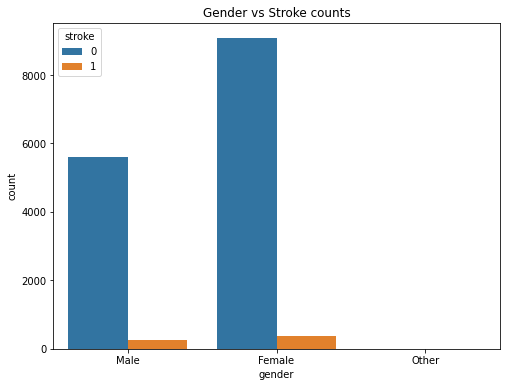

In [30]:
# gender가 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'gender', hue='stroke', data = train )
ax.set_title('Gender vs Stroke counts')
plt.show()

In [31]:
# gender 고유값별 개수 확인
train['gender'].value_counts()

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

In [32]:
# 교차분석표 함수화 처리
def make_cross_tab(df, feature):
  cross_tab = pd.crosstab( df[feature], df['stroke'], normalize='index' ) *100
  cross_tab.reset_index(inplace=True)
  return cross_tab

In [33]:
make_cross_tab(train,'gender')
# 이를 통해서 여성보다는 남성이 뇌졸증이 걸리기 쉽다
# Female 중 약 3.89%, Male 중 약 4.50%가 뇌졸중 환자로 확인됨
# other은 1명 존재하며 뇌졸중 환자가 아님 -> 이상치로 확인 

stroke,gender,0,1
0,Female,96.104171,3.895829
1,Male,95.492573,4.507427
2,Other,100.000000,0.000000


#### hypertension

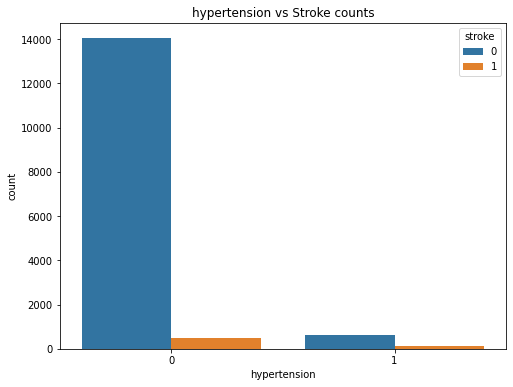

In [34]:
# hypertension이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'hypertension', hue='stroke', data = train )
ax.set_title('hypertension vs Stroke counts')
plt.show()

In [35]:
make_cross_tab(train,'hypertension')
# 고혈압을 앓고 있는 사람들은 고혈압이 없는 사람들보다 뇌졸중에 걸릴 확률이 더 높다.

stroke,hypertension,0,1
0,0,96.534415,3.465585
1,1,83.180026,16.819974


#### heart_disease

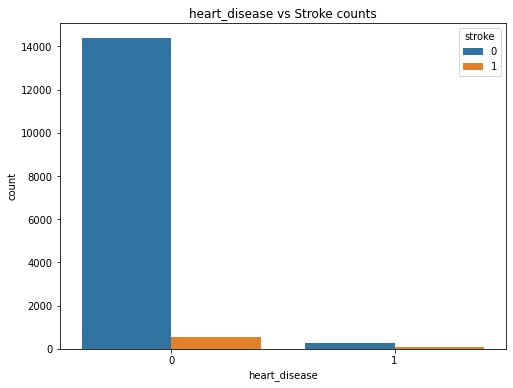

In [36]:
# heart_disease이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'heart_disease', hue='stroke', data = train )
ax.set_title('heart_disease vs Stroke counts')
plt.show()

In [37]:
make_cross_tab(train,'heart_disease')
# 심장병을 앓고 있는 사람들은 심장병이 없는 사람들보다 뇌졸중에 걸릴 확률이 더 높다.

stroke,heart_disease,0,1
0,0,96.213287,3.786713
1,1,81.512605,18.487395


#### ever_married

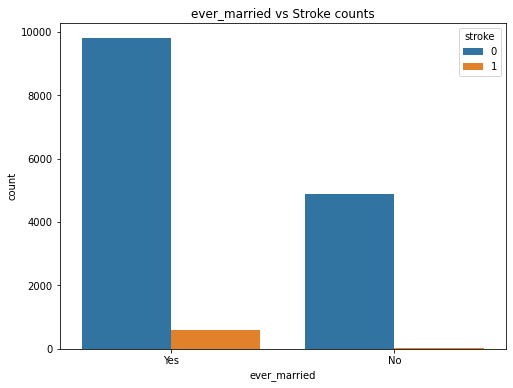

In [38]:
# ever_married이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'ever_married', hue='stroke', data = train )
ax.set_title('ever_married vs Stroke counts')
plt.show()

In [39]:
make_cross_tab(train,'ever_married')

stroke,ever_married,0,1
0,No,99.166497,0.833503
1,Yes,94.309100,5.690900


#### work_type

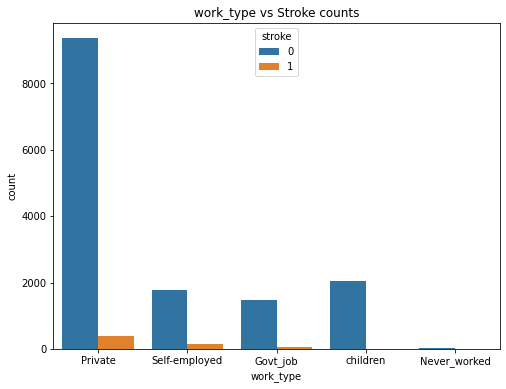

In [40]:
# heart_disease이 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'work_type', hue='stroke', data = train )
ax.set_title('work_type vs Stroke counts')
plt.show()

In [41]:
# work_type 고유값별 개수 확인
train['work_type'].value_counts()

Private          9752
children         2038
Self-employed    1939
Govt_job         1533
Never_worked       42
Name: work_type, dtype: int64

In [42]:
make_cross_tab(train,'work_type')
# 일을 해본 사람들은 뇌졸중 위험 확률이 가장 높다 / 일을 아예 한 사람은 가장 낮음
# -> 다만 데이터 분포가 적은 Never_worked, children과  Govt_job	, Private을 합쳐서 새로운 피처를 만들수 있겠다	

stroke,work_type,0,1
0,Govt_job,95.499022,4.500978
1,Never_worked,100.000000,0.000000
2,Private,95.857260,4.142740
3,Self-employed,91.851470,8.148530
4,children,99.950932,0.049068


#### Residence_type

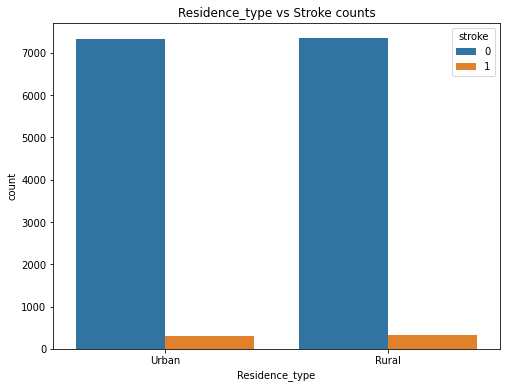

In [43]:
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'Residence_type', hue='stroke', data = train )
ax.set_title('Residence_type vs Stroke counts')
plt.show()

In [44]:
make_cross_tab(train,'Residence_type')
# -> 대상 변수에 대한 값의 영향이 동일하기 때문에 이 기능인 Residence_type을 제거하는 것을 고려

stroke,Residence_type,0,1
0,Rural,95.863779,4.136221
1,Urban,95.876963,4.123037


#### smoking_status

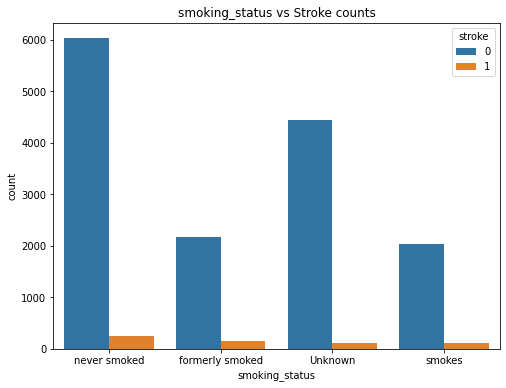

In [45]:
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'smoking_status', hue='stroke', data = train )
ax.set_title('smoking_status vs Stroke counts')
plt.show()

In [46]:
make_cross_tab(train,'smoking_status')
# 알려지지 않은 값과 절대 흡연하지 않는 값은 뇌졸중에 걸릴 가능성이 낮은 반면 
# 이전에 흡연된 값과 흡연 값은 뇌졸중에 걸릴 가능성이 더 높습니다.

stroke,smoking_status,0,1
0,Unknown,97.622716,2.377284
1,formerly smoked,93.196406,6.803594
2,never smoked,95.908295,4.091705
3,smokes,94.960336,5.039664


### Stripplot

- age :  뇌졸중에 걸린 사람들은 일반적으로 40-80 사이에 분포되어 있고, 여성이 남성보다 더 많다, 젊은 사람들은 거의 X 
- bmi : 뇌졸중 환자의 bmi 수치는 약 20 ~ 40에 분포되어 있으나 뇌졸중 환자가 아닌 사람 또한 비슷한 구간에 분표되어 있어 변별력은 없을 것이라고 예상됨
- 평균 당수치 : 뇌졸중 환자 중 당 수치가 높은 사람보다 낮은 사람이 많다 => 당수치와의 상관관계는 적은 것으로 예상됨

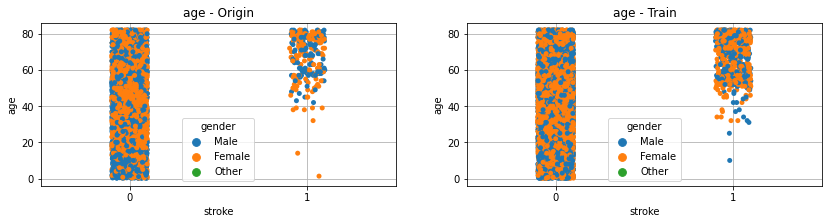

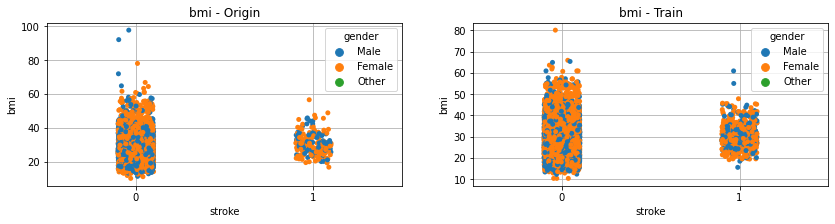

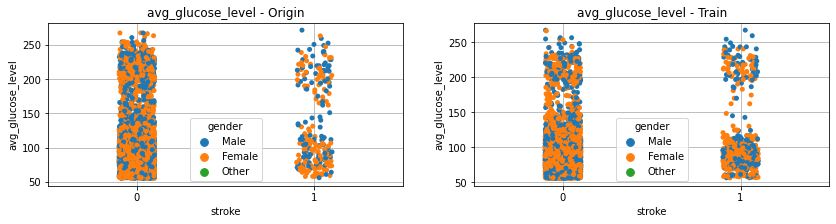

In [47]:
# 범주형 데이터의 산점도 : stripplot : (https://steadiness-193.tistory.com/184) 

strip_feat = ['age','bmi','avg_glucose_level']

for f in strip_feat:
  plt.figure(figsize=(14,3))
  ax1 = plt.subplot(1,2,1)
  sns.stripplot( x="stroke", y = f, hue="gender", data=origin)
  plt.title(f + ' - Origin')
  plt.grid()
  ax2 = plt.subplot(1,2,2)
  sns.stripplot( x="stroke", y = f,hue="gender", data=train)
  plt.title(f + ' - Train')
  plt.grid()
  plt.show() 

### Lineplot

- 첫 번째 그래프의 경우, 20-60세 사이의 사람들은 높은 bmi 값을 가진다
- 두 번째 그래프에 따르면, 40세 이상의 사람들은 당 수치가 높다는 것을 의미하는데, 이는 이 사람들이 당뇨병 환자가 될 수 있다.
- 마지막 그래프의 경우, 당 수치가 낮으면 bmi도 같이 낮아진다(상관관계).

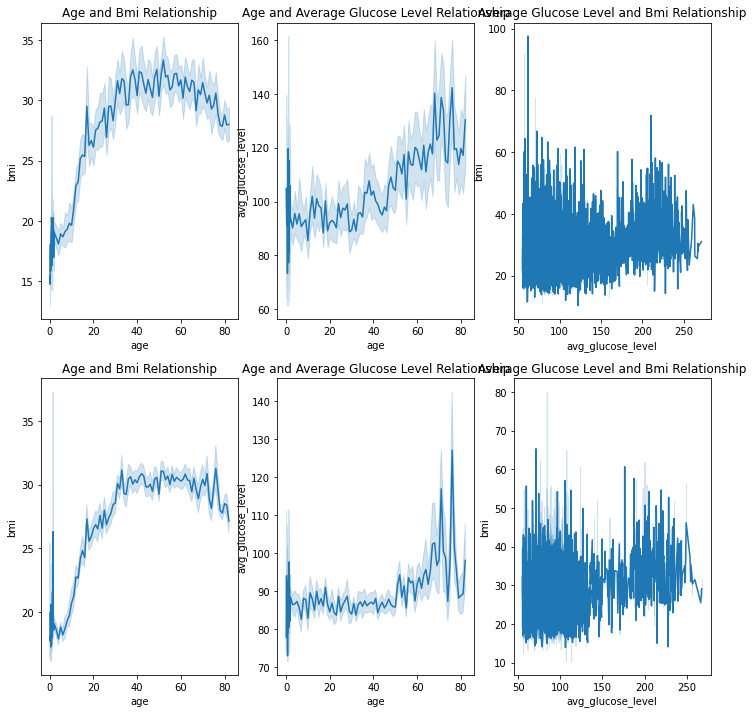

In [48]:
fig, axes = plt.subplots(figsize=(12,12), ncols=3, nrows=2)

sns.set_style('whitegrid')

ax1 = sns.lineplot(x="age",y="bmi",data=origin, ax=axes[0][0])
ax1.set_title("Age and Bmi Relationship")

ax2 = sns.lineplot(x="age",y="avg_glucose_level",data=origin, ax=axes[0][1])
ax2.set_title("Age and Average Glucose Level Relationship")

ax3 = sns.lineplot(x="avg_glucose_level",y="bmi",data=origin, ax=axes[0][2])
ax3.set_title("Average Glucose Level and Bmi Relationship")

ax4 = sns.lineplot(x="age",y="bmi",data=train, ax=axes[1][0])
ax4.set_title("Age and Bmi Relationship")

ax5 = sns.lineplot(x="age",y="avg_glucose_level",data=train, ax=axes[1][1])
ax5.set_title("Age and Average Glucose Level Relationship")

ax6 = sns.lineplot(x="avg_glucose_level",y="bmi",data=train, ax=axes[1][2])
ax6.set_title("Average Glucose Level and Bmi Relationship")

plt.show()

## Heatmap

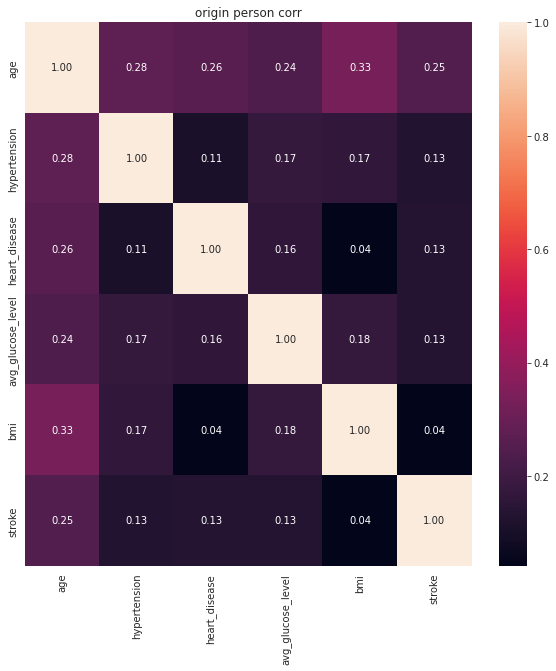

In [49]:
plt.figure(figsize=(10,10))
sns.heatmap(origin.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("origin person corr")
plt.show()

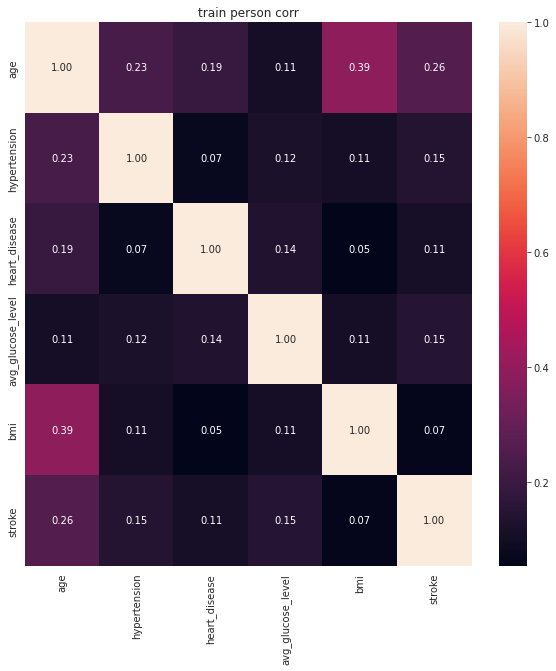

In [50]:
plt.figure(figsize=(10,10))
sns.heatmap(train.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("train person corr")
plt.show()

# Age, hypertension,avg_glucose_level,heart_disease, bmi대체적으로 상관관계가 있음

# 피쳐 엔지니어링

In [51]:
# 데이터 가져오기 
data_path = '/content/drive/MyDrive/cloud_ai/2차_실기평가/2차_모듈/'

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv') 
origin = pd.read_csv(data_path + 'healthcare-dataset-stroke-data.csv')

origin.shape, train.shape, test.shape, submission.shape

((5110, 12), (15304, 12), (10204, 11), (10204, 2))

In [52]:
# 뇌졸증 환자에 대해서만 가져오기
origin_stroke_1 =  origin[origin[['stroke']].all(1)]
origin_stroke_1.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [53]:
# 트레인 데이터 셋에 추가
train = pd.concat([origin_stroke_1,train])
train.shape

(15553, 12)

## 데이터 합치기

In [54]:
all_data = pd.concat([train,test], ignore_index=True)
all_data

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1.0
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1.0
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1.0
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1.0
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25752,25503,Female,27.0,0,0,No,Private,Urban,75.77,17.6,never smoked,NaN
25753,25504,Male,49.0,0,0,Yes,Private,Urban,102.91,26.7,Unknown,NaN
25754,25505,Female,3.0,0,0,No,children,Rural,104.04,18.3,Unknown,NaN
25755,25506,Male,31.0,0,0,Yes,Private,Urban,82.41,28.7,never smoked,NaN


In [55]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 25757 non-null  int64  
 1   gender             25757 non-null  object 
 2   age                25757 non-null  float64
 3   hypertension       25757 non-null  int64  
 4   heart_disease      25757 non-null  int64  
 5   ever_married       25757 non-null  object 
 6   work_type          25757 non-null  object 
 7   Residence_type     25757 non-null  object 
 8   avg_glucose_level  25757 non-null  float64
 9   bmi                25717 non-null  float64
 10  smoking_status     25757 non-null  object 
 11  stroke             15553 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 2.4+ MB


In [56]:
all_data.isnull().sum()

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                     40
smoking_status           0
stroke               10204
dtype: int64

In [57]:
all_data.nunique().sort_values()

hypertension             2
heart_disease            2
ever_married             2
Residence_type           2
stroke                   2
gender                   3
smoking_status           4
work_type                5
age                    109
bmi                    441
avg_glucose_level     4391
id                   25677
dtype: int64

In [58]:
# 앞 선 EDA 결과를 통해서 id, Residence_type 제거
all_data.drop(columns=['id','Residence_type'],inplace=True)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             25757 non-null  object 
 1   age                25757 non-null  float64
 2   hypertension       25757 non-null  int64  
 3   heart_disease      25757 non-null  int64  
 4   ever_married       25757 non-null  object 
 5   work_type          25757 non-null  object 
 6   avg_glucose_level  25757 non-null  float64
 7   bmi                25717 non-null  float64
 8   smoking_status     25757 non-null  object 
 9   stroke             15553 non-null  float64
dtypes: float64(4), int64(2), object(4)
memory usage: 2.0+ MB


## 결측치 처리

In [59]:
# 앞 서 origin 데이터에서 bmi를 최빈값으로 처리

from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="most_frequent")

all_data[['bmi']] = imputer.fit_transform(all_data[['bmi']])

In [60]:
all_data.isnull().sum()

gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
avg_glucose_level        0
bmi                      0
smoking_status           0
stroke               10204
dtype: int64

## 범주형 데이터 인코딩

- gender 
  - gender의 other를 female로 변환


In [61]:
# gender의 other 위치 확인
all_data[all_data['gender'].str.contains('Other')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
9612,Other,9.0,0,0,No,children,96.04,18.0,Unknown,0.0
20182,Other,56.0,0,0,Yes,Private,102.53,35.0,Unknown,NaN


In [62]:
# Other 값을 Male로 변경
all_data.loc[all_data.index.isin([9612, 20182]), 'gender'] = 'Female'

In [63]:
# 데이터 변경 후, 교차 분석표 재확인
make_cross_tab(all_data,'gender')

stroke,gender,0.0,1.0
0,Female,94.691281,5.308719
1,Male,93.763621,6.236379


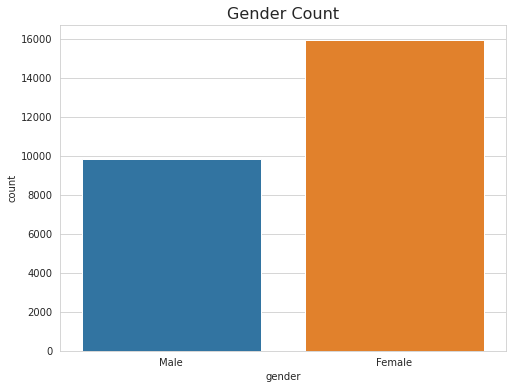

In [64]:
# 시각화 재확인
plt.figure(figsize=(8, 6))

ax = sns.countplot(x = 'gender', data = all_data)
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

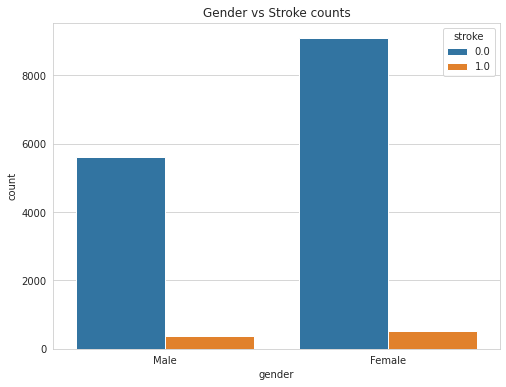

In [65]:
# gender가 storke에 미치는 영향을 알아보자
plt.figure(figsize=(8, 6))
ax = sns.countplot( x = 'gender', hue='stroke', data = all_data )
ax.set_title('Gender vs Stroke counts')
plt.show()

- smoking_status
  - 비흡연 vs 흡연 => 이진형 형태로 변환
  - smoking_status의 Unknown을 never_smoked로 변환
  - smoking_status의 formerly smoked를 smoked로 변환

In [66]:
print(pd.unique(all_data["smoking_status"]))

['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [67]:
# smoking_status에 unknown 확인
all_data[all_data['smoking_status'].str.contains('Unknown')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
8,Female,59.00,0,0,Yes,Private,76.15,23.4,Unknown,1.0
9,Female,78.00,0,0,Yes,Private,58.57,24.2,Unknown,1.0
13,Male,78.00,0,1,Yes,Private,219.84,23.4,Unknown,1.0
19,Male,57.00,0,1,No,Govt_job,217.08,23.4,Unknown,1.0
23,Male,82.00,0,1,Yes,Private,208.30,32.5,Unknown,1.0
...,...,...,...,...,...,...,...,...,...,...
25731,Female,1.24,0,0,No,children,92.13,13.8,Unknown,NaN
25742,Female,57.00,0,0,Yes,Private,77.93,35.7,Unknown,NaN
25753,Male,49.00,0,0,Yes,Private,102.91,26.7,Unknown,NaN
25754,Female,3.00,0,0,No,children,104.04,18.3,Unknown,NaN


In [68]:
all_data[all_data['smoking_status'].str.contains('formerly smoked')]

,gender,age,hypertension,heart_disease,ever_married,work_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,228.69,36.6,formerly smoked,1.0
5,Male,81.0,0,0,Yes,Private,186.21,29.0,formerly smoked,1.0
24,Male,71.0,0,0,Yes,Private,102.87,27.2,formerly smoked,1.0
26,Female,65.0,0,0,Yes,Private,100.98,28.2,formerly smoked,1.0
29,Male,59.0,0,0,Yes,Private,211.78,23.4,formerly smoked,1.0
...,...,...,...,...,...,...,...,...,...,...
25740,Male,43.0,0,0,Yes,Govt_job,85.07,20.0,formerly smoked,NaN
25744,Female,34.0,0,0,Yes,Self-employed,81.98,29.0,formerly smoked,NaN
25745,Female,43.0,0,0,Yes,Govt_job,84.99,25.4,formerly smoked,NaN
25747,Female,33.0,0,0,Yes,Private,105.19,27.4,formerly smoked,NaN


In [69]:
# Unknown -> never smoked / 'formerly smoked' -> 'smokes' 변경
all_data["smoking_status"] = all_data["smoking_status"].replace({
    'Unknown': 'never smoked',
    'formerly smoked': 'smokes'
})

In [70]:
all_data['smoking_status'].unique() 

array(['smokes', 'never smoked'], dtype=object)

In [71]:
# 데이터 변경 후, 교차 분석표 재확인
make_cross_tab(all_data,'smoking_status')

stroke,smoking_status,0.0,1.0
0,never smoked,95.420126,4.579874
1,smokes,91.746516,8.253484


### One-Hot Encoding

In [72]:
all_data.nunique().sort_values()

gender                  2
hypertension            2
heart_disease           2
ever_married            2
smoking_status          2
stroke                  2
work_type               5
age                   109
bmi                   441
avg_glucose_level    4391
dtype: int64

In [73]:
nom_features = ['gender','hypertension','heart_disease','ever_married','smoking_status','work_type']
all_data[nom_features].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          25757 non-null  object
 1   hypertension    25757 non-null  int64 
 2   heart_disease   25757 non-null  int64 
 3   ever_married    25757 non-null  object
 4   smoking_status  25757 non-null  object
 5   work_type       25757 non-null  object
dtypes: int64(2), object(4)
memory usage: 1.2+ MB


In [74]:
all_data[nom_features]
# hypertension,heart_disease	이진형이므로 원-핫 인코딩 제외

,gender,hypertension,heart_disease,ever_married,smoking_status,work_type
0,Male,0,1,Yes,smokes,Private
1,Female,0,0,Yes,never smoked,Self-employed
2,Male,0,1,Yes,never smoked,Private
3,Female,0,0,Yes,smokes,Private
4,Female,1,0,Yes,never smoked,Self-employed
...,...,...,...,...,...,...
25752,Female,0,0,No,never smoked,Private
25753,Male,0,0,Yes,never smoked,Private
25754,Female,0,0,No,never smoked,children
25755,Male,0,0,Yes,never smoked,Private


In [75]:
from sklearn.preprocessing import OneHotEncoder

nom_features = ['gender','ever_married','smoking_status','work_type']

onehot = OneHotEncoder() # OneHotEncoder 객체 생성

# 원-핫 인코딩 적용
print( all_data[nom_features].info() )
encoded_nom_matrix = onehot.fit_transform(all_data[nom_features])

encoded_nom_matrix

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25757 entries, 0 to 25756
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gender          25757 non-null  object
 1   ever_married    25757 non-null  object
 2   smoking_status  25757 non-null  object
 3   work_type       25757 non-null  object
dtypes: object(4)
memory usage: 805.0+ KB
None


<25757x11 sparse matrix of type '<class 'numpy.float64'>'
	with 103028 stored elements in Compressed Sparse Row format>

In [76]:
all_data = all_data.drop(nom_features, axis=1) # 기존 명목형 피처 삭제
all_data.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
0,67.0,0,1,228.69,36.6,1.0
1,61.0,0,0,202.21,23.4,1.0
2,80.0,0,1,105.92,32.5,1.0
3,49.0,0,0,171.23,34.4,1.0
4,79.0,1,0,174.12,24.0,1.0


## 파생 피처 생성

- 나이별 bmi 비율 어느정도 되는가?
- 나이 * BMI
- BMI Prime : [BMI Prime Calculator](https://captaincalculator.com/health/weight/bmi-prime-calculator/) 참고
- 비만도 = 평균 당 수치 * bmi / 1000

  - [5th Place Solution](https://www.kaggle.com/competitions/playground-series-s3e2/discussion/378780)

In [77]:
def generate_features(df):
    df['age/bmi'] = df.age / df.bmi
    df['age*bmi'] = df.age * df.bmi
    df['bmi/prime'] = df.bmi / 25
    df['obesity'] = df.avg_glucose_level * df.bmi / 1000
    return df

In [78]:
generate_features(all_data)

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age/bmi,age*bmi,bmi/prime,obesity
0,67.0,0,1,228.69,36.6,1.0,1.830601,2452.2,1.464,8.370054
1,61.0,0,0,202.21,23.4,1.0,2.606838,1427.4,0.936,4.731714
2,80.0,0,1,105.92,32.5,1.0,2.461538,2600.0,1.300,3.442400
3,49.0,0,0,171.23,34.4,1.0,1.424419,1685.6,1.376,5.890312
4,79.0,1,0,174.12,24.0,1.0,3.291667,1896.0,0.960,4.178880
...,...,...,...,...,...,...,...,...,...,...
25752,27.0,0,0,75.77,17.6,NaN,1.534091,475.2,0.704,1.333552
25753,49.0,0,0,102.91,26.7,NaN,1.835206,1308.3,1.068,2.747697
25754,3.0,0,0,104.04,18.3,NaN,0.163934,54.9,0.732,1.903932
25755,31.0,0,0,82.41,28.7,NaN,1.080139,889.7,1.148,2.365167


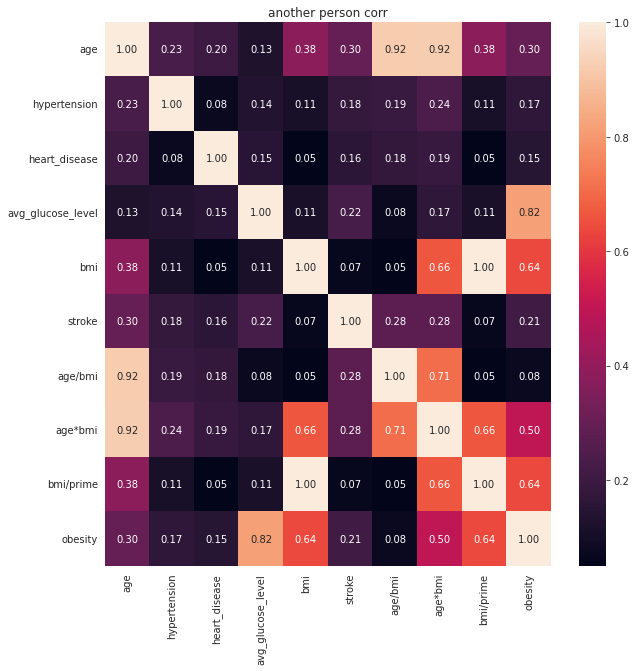

In [79]:
plt.figure(figsize=(10,10))
sns.heatmap(all_data.corr(), 
            cbar=True, 
            annot=True, 
            fmt='.2f')
plt.title("another person corr")
plt.show()
# stroke 예측 시 어느정도 영향력이 있음

## 피처 스케일링

In [80]:
from sklearn.preprocessing import RobustScaler

num_features = ['age', 'avg_glucose_level', 'bmi', 'age/bmi', 'age*bmi', 'bmi/prime', 'obesity']

robust = RobustScaler()

all_data[num_features] = robust.fit_transform(all_data[num_features])

In [81]:
all_data

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age/bmi,age*bmi,bmi/prime,obesity
0,0.774194,0,1,6.512250,1.047059,1.0,0.363324,1.116524,1.047059,6.260749
1,0.580645,0,0,5.310799,-0.505882,1.0,1.098161,0.152732,-0.505882,2.483716
2,1.193548,0,1,0.941924,0.564706,1.0,0.960611,1.255525,0.564706,1.145254
3,0.193548,0,0,3.905172,0.788235,1.0,-0.021196,0.395561,0.788235,3.686480
4,1.161290,1,0,4.036298,-0.435294,1.0,1.746466,0.593436,-0.435294,1.909808
...,...,...,...,...,...,...,...,...,...,...
25752,-0.516129,0,0,-0.426044,-1.188235,NaN,0.082627,-0.742782,-1.188235,-1.043983
25753,0.193548,0,0,0.805354,-0.117647,NaN,0.367683,0.040722,-0.117647,0.424069
25754,-1.290323,0,0,0.856624,-1.105882,NaN,-1.214454,-1.138061,-1.105882,-0.451860
25755,-0.387097,0,0,-0.124773,0.117647,NaN,-0.347113,-0.352958,0.117647,0.026957


# 스케일링된 데이터 병합

In [82]:
# 병합 전, 타겟변수 제거
all_data.drop(columns=['stroke'],inplace=True)

In [83]:
all_data

,age,hypertension,heart_disease,avg_glucose_level,bmi,age/bmi,age*bmi,bmi/prime,obesity
0,0.774194,0,1,6.512250,1.047059,0.363324,1.116524,1.047059,6.260749
1,0.580645,0,0,5.310799,-0.505882,1.098161,0.152732,-0.505882,2.483716
2,1.193548,0,1,0.941924,0.564706,0.960611,1.255525,0.564706,1.145254
3,0.193548,0,0,3.905172,0.788235,-0.021196,0.395561,0.788235,3.686480
4,1.161290,1,0,4.036298,-0.435294,1.746466,0.593436,-0.435294,1.909808
...,...,...,...,...,...,...,...,...,...
25752,-0.516129,0,0,-0.426044,-1.188235,0.082627,-0.742782,-1.188235,-1.043983
25753,0.193548,0,0,0.805354,-0.117647,0.367683,0.040722,-0.117647,0.424069
25754,-1.290323,0,0,0.856624,-1.105882,-1.214454,-1.138061,-1.105882,-0.451860
25755,-0.387097,0,0,-0.124773,0.117647,-0.347113,-0.352958,0.117647,0.026957


In [84]:
encoded_nom_matrix

<25757x11 sparse matrix of type '<class 'numpy.float64'>'
	with 103028 stored elements in Compressed Sparse Row format>

In [85]:
from scipy import sparse



# 인코딩 및 스케일링된 피처 합치기
all_data_sprs = sparse.hstack([sparse.csr_matrix(all_data),
                               encoded_nom_matrix],
                              format='csr')
all_data_sprs

<25757x20 sparse matrix of type '<class 'numpy.float64'>'
	with 284360 stored elements in Compressed Sparse Row format>

# 데이터 나누기

In [86]:
num_train = len(train) # 훈련 데이터 개수 

# 훈련 데이터와 테스트 데이터 나누기
X = all_data_sprs[:num_train] # 0 ~ num_train - 1행
X_test = all_data_sprs[num_train:] # num_train ~ 마지막 행
y = train['stroke'] 

X.shape, X_test.shape, y.shape

((15553, 20), (10204, 20), (15553,))

In [87]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size=0.2,random_state=42)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(12442, 20) (3111, 20) (12442,) (3111,)


# 베이스라인 구축

In [88]:
%%time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# 이진 분류, 선형 모델을 내부적으로 가지고, 피처가 많아도 학습 속도가 빠른 로지스틱 회귀 사용
clf = LogisticRegression()

# 하이퍼파라미터 값 목록
clf_params = {'C':[0.001, 0.01, 0.1, 1], # 규제 강도, 높을 수록 강함
             'max_iter':[100, 300, 500, 700, 1000], #  모델 성능을 오리기 위해서 학습의 반복 횟수 제한
             'solver':['liblinear'], # 과적합 방지 지표 :  L1,L2를 모두 지원
             'random_state':[0,42,100]}

# 그리드서치 객체 생성
gridsearch_logistic_model = GridSearchCV(clf,clf_params,scoring='roc_auc',cv=10)
# 그리드서치 수행
gridsearch_logistic_model.fit(X_train, y_train)

CPU times: user 11.7 s, sys: 12.6 ms, total: 11.7 s
Wall time: 11.8 s


GridSearchCV(cv=10, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1],
                         'max_iter': [100, 300, 500, 700, 1000],
                         'random_state': [0, 42, 100],
                         'solver': ['liblinear']},
             scoring='roc_auc')

In [89]:
print('최적 하이퍼파라미터:', gridsearch_logistic_model.best_params_)
print('위 하이퍼파리머터 사용시 roc_auc ', gridsearch_logistic_model.best_score_)

최적 하이퍼파라미터: {'C': 1, 'max_iter': 100, 'random_state': 0, 'solver': 'liblinear'}
위 하이퍼파리머터 사용시 roc_auc  0.8858885496506476


In [90]:
print(X.shape, y.shape, X_test.shape)
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

(15553, 20) (15553,) (10204, 20)
(12442, 20) (3111, 20) (12442,) (3111,)


In [91]:
y_valid_preds = gridsearch_logistic_model.predict_proba(X_valid)[:, 1]

In [92]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수

# 검증 데이터 ROC AUC
roc_auc = roc_auc_score(y_valid, y_valid_preds)

print(f'검증 데이터 ROC AUC : {roc_auc:.4f}')

검증 데이터 ROC AUC : 0.8942


In [93]:
# 타깃값 1일 확률 예측
y_preds = gridsearch_logistic_model.best_estimator_.predict_proba(X_test)[:,1]
y_preds

array([0.04549696, 0.17403334, 0.00143711, ..., 0.00118411, 0.00435641,
       0.00078803])

In [94]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

preds = minmax.fit_transform(y_preds.reshape(-1, 1))

In [95]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': preds.reshape(-1, )
})
submission.head()

,id,stroke
0,15304,0.056775
1,15305,0.218195
2,15306,0.001443
3,15307,0.075844
4,15308,0.009856


In [96]:
submission.to_csv('submission.csv', index=False )
# Private Score: 0.88878 / Public score: 0.86597

# 모델 선정 및 비교

- sparse matrix -> 배열 형태로 변환 > train,test
- y는 train에서 가져온값

In [97]:
X_train_df = pd.DataFrame(X.toarray()).reset_index(drop=True)
X_test_df = pd.DataFrame(X_test.toarray()).reset_index(drop=True)
y_train_df = pd.DataFrame(y, columns=['stroke']).reset_index(drop=True)

In [98]:
X_train_df.shape, X_test_df.shape, y_train_df

((15553, 20), (10204, 20),        stroke
 0           1
 1           1
 2           1
 3           1
 4           1
 ...       ...
 15548       0
 15549       0
 15550       0
 15551       0
 15552       0
 
 [15553 rows x 1 columns])

In [99]:
data = pd.concat([X_train_df, y_train_df], axis=1)
data

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,stroke
0,0.774194,0.0,1.0,6.512250,1.047059,0.363324,1.116524,1.047059,6.260749,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
1,0.580645,0.0,0.0,5.310799,-0.505882,1.098161,0.152732,-0.505882,2.483716,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
2,1.193548,0.0,1.0,0.941924,0.564706,0.960611,1.255525,0.564706,1.145254,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1
3,0.193548,0.0,0.0,3.905172,0.788235,-0.021196,0.395561,0.788235,3.686480,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,1.161290,1.0,0.0,4.036298,-0.435294,1.746466,0.593436,-0.435294,1.909808,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15548,-0.677419,0.0,0.0,-0.568512,-0.964706,-0.301611,-0.786232,-0.964706,-0.958096,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0
15549,0.096774,1.0,0.0,0.727314,0.517647,-0.013051,0.199003,0.517647,0.943650,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0
15550,1.032258,0.0,0.0,0.114791,-0.176471,1.340278,0.658328,-0.176471,-0.043312,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
15551,0.096774,0.0,0.0,0.724592,-0.611765,0.565762,-0.216308,-0.611765,-0.066206,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [100]:
from sklearn.model_selection import train_test_split

y = data['stroke']
X = data.drop(columns=['stroke'])

# 훈련 데이터, 검증 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2,random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(12442, 20) (3111, 20) (12442,) (3111,)


In [101]:
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

def roc_auc_cv(model):
    # cv별로 학습하는 함수
    tscv = TimeSeriesSplit(n_splits=10)
    roc_auc_list = []
    model_name = model.__class__.__name__
    for _, (train_index, test_index) in tqdm(enumerate(tscv.split(X_train), start=1), desc=f'{model_name} Cross Validations...', total=10):
        X_train1, X_test1 = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train1, y_test1 = y_train.iloc[train_index], y_train.iloc[test_index]
        clf = model.fit(X_train1, y_train1)
        pred = clf.predict_proba(X_test1)[:, 1]
        roc_auc = roc_auc_score(y_test1, pred)
        roc_auc_list.append(roc_auc)
    return model_name, roc_auc_list

def print_roc_auc_score(model):
    # cv별 프린팅, 평균 저장
    model_name, score = roc_auc_cv(model)
    for i, r in enumerate(score, start=1):
        print(f'{i} FOLDS: {model_name} ROC AUC: {r:.4f}')
    print(f'\n{model_name} mean ROC AUC: {np.mean(score):.4f}')
    print('='*40)
    return model_name, np.mean(score)

In [102]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 13.3 MB/s eta 0:00:00


In [103]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


lr = LogisticRegression()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()
cat = CatBoostClassifier()
ada = AdaBoostClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

In [104]:
models = []
scores = []
for model in [lr, dt, rf, gb, cat, xgb, ada, lgbm]:
    model_name, mean_score = print_roc_auc_score(model)
    models.append(model_name)
    scores.append(mean_score)

LogisticRegression Cross Validations...:  20%|██        | 2/10 [00:00<00:00, 15.94it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

LogisticRegression Cross Validations...:  40%|████      | 4/10 [00:00<00:00, 12.33it/s]/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the docum

1 FOLDS: LogisticRegression ROC AUC: 0.9085
2 FOLDS: LogisticRegression ROC AUC: 0.8347
3 FOLDS: LogisticRegression ROC AUC: 0.8709
4 FOLDS: LogisticRegression ROC AUC: 0.8618
5 FOLDS: LogisticRegression ROC AUC: 0.9278
6 FOLDS: LogisticRegression ROC AUC: 0.8943
7 FOLDS: LogisticRegression ROC AUC: 0.8732
8 FOLDS: LogisticRegression ROC AUC: 0.8914
9 FOLDS: LogisticRegression ROC AUC: 0.9011
10 FOLDS: LogisticRegression ROC AUC: 0.8984

LogisticRegression mean ROC AUC: 0.8862


DecisionTreeClassifier Cross Validations...: 100%|██████████| 10/10 [00:00<00:00, 19.26it/s]


1 FOLDS: DecisionTreeClassifier ROC AUC: 0.6357
2 FOLDS: DecisionTreeClassifier ROC AUC: 0.6202
3 FOLDS: DecisionTreeClassifier ROC AUC: 0.6033
4 FOLDS: DecisionTreeClassifier ROC AUC: 0.5630
5 FOLDS: DecisionTreeClassifier ROC AUC: 0.6521
6 FOLDS: DecisionTreeClassifier ROC AUC: 0.5609
7 FOLDS: DecisionTreeClassifier ROC AUC: 0.6097
8 FOLDS: DecisionTreeClassifier ROC AUC: 0.6462
9 FOLDS: DecisionTreeClassifier ROC AUC: 0.6281
10 FOLDS: DecisionTreeClassifier ROC AUC: 0.6309

DecisionTreeClassifier mean ROC AUC: 0.6150


RandomForestClassifier Cross Validations...: 100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


1 FOLDS: RandomForestClassifier ROC AUC: 0.8775
2 FOLDS: RandomForestClassifier ROC AUC: 0.8071
3 FOLDS: RandomForestClassifier ROC AUC: 0.8573
4 FOLDS: RandomForestClassifier ROC AUC: 0.8639
5 FOLDS: RandomForestClassifier ROC AUC: 0.8869
6 FOLDS: RandomForestClassifier ROC AUC: 0.8552
7 FOLDS: RandomForestClassifier ROC AUC: 0.8568
8 FOLDS: RandomForestClassifier ROC AUC: 0.8649
9 FOLDS: RandomForestClassifier ROC AUC: 0.8740
10 FOLDS: RandomForestClassifier ROC AUC: 0.8698

RandomForestClassifier mean ROC AUC: 0.8613


GradientBoostingClassifier Cross Validations...: 100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


1 FOLDS: GradientBoostingClassifier ROC AUC: 0.8578
2 FOLDS: GradientBoostingClassifier ROC AUC: 0.8320
3 FOLDS: GradientBoostingClassifier ROC AUC: 0.8692
4 FOLDS: GradientBoostingClassifier ROC AUC: 0.8609
5 FOLDS: GradientBoostingClassifier ROC AUC: 0.9261
6 FOLDS: GradientBoostingClassifier ROC AUC: 0.8903
7 FOLDS: GradientBoostingClassifier ROC AUC: 0.8733
8 FOLDS: GradientBoostingClassifier ROC AUC: 0.8995
9 FOLDS: GradientBoostingClassifier ROC AUC: 0.8981
10 FOLDS: GradientBoostingClassifier ROC AUC: 0.9061

GradientBoostingClassifier mean ROC AUC: 0.8813


CatBoostClassifier Cross Validations...:   0%|          | 0/10 [00:00<?, ?it/s]

Learning rate set to 0.010862
0:	learn: 0.6761931	total: 48.2ms	remaining: 48.2s
1:	learn: 0.6626058	total: 50.1ms	remaining: 25s
2:	learn: 0.6458962	total: 51.9ms	remaining: 17.2s
3:	learn: 0.6305518	total: 53.6ms	remaining: 13.4s
4:	learn: 0.6166417	total: 55.4ms	remaining: 11s
5:	learn: 0.6010183	total: 57.2ms	remaining: 9.47s
6:	learn: 0.5842825	total: 58.9ms	remaining: 8.36s
7:	learn: 0.5714411	total: 60.7ms	remaining: 7.53s
8:	learn: 0.5573807	total: 62.5ms	remaining: 6.89s
9:	learn: 0.5453640	total: 64.3ms	remaining: 6.37s
10:	learn: 0.5310793	total: 66.1ms	remaining: 5.95s
11:	learn: 0.5191334	total: 67.9ms	remaining: 5.59s
12:	learn: 0.5063533	total: 69.7ms	remaining: 5.29s
13:	learn: 0.4941351	total: 71.7ms	remaining: 5.05s
14:	learn: 0.4841061	total: 73.3ms	remaining: 4.81s
15:	learn: 0.4740852	total: 75.1ms	remaining: 4.62s
16:	learn: 0.4638762	total: 76.9ms	remaining: 4.45s
17:	learn: 0.4535958	total: 78.6ms	remaining: 4.29s
18:	learn: 0.4436520	total: 80.4ms	remaining: 4.

CatBoostClassifier Cross Validations...:  10%|█         | 1/10 [00:02<00:23,  2.58s/it]

991:	learn: 0.0516931	total: 2.31s	remaining: 18.7ms
992:	learn: 0.0516782	total: 2.32s	remaining: 16.3ms
993:	learn: 0.0516264	total: 2.32s	remaining: 14ms
994:	learn: 0.0515820	total: 2.33s	remaining: 11.7ms
995:	learn: 0.0515204	total: 2.33s	remaining: 9.38ms
996:	learn: 0.0514802	total: 2.34s	remaining: 7.04ms
997:	learn: 0.0514512	total: 2.35s	remaining: 4.7ms
998:	learn: 0.0513969	total: 2.35s	remaining: 2.35ms
999:	learn: 0.0513775	total: 2.36s	remaining: 0us
Learning rate set to 0.014601
0:	learn: 0.6695585	total: 5.83ms	remaining: 5.82s
1:	learn: 0.6513078	total: 10.9ms	remaining: 5.43s
2:	learn: 0.6279106	total: 17.1ms	remaining: 5.67s
3:	learn: 0.6090341	total: 23.2ms	remaining: 5.77s
4:	learn: 0.5876443	total: 30.2ms	remaining: 6s
5:	learn: 0.5673486	total: 35.3ms	remaining: 5.85s
6:	learn: 0.5456590	total: 41.5ms	remaining: 5.89s
7:	learn: 0.5287908	total: 61.6ms	remaining: 7.64s
8:	learn: 0.5102631	total: 70.3ms	remaining: 7.75s
9:	learn: 0.4948970	total: 74.1ms	remaining

CatBoostClassifier Cross Validations...:  20%|██        | 2/10 [00:10<00:43,  5.46s/it]

Learning rate set to 0.01736
0:	learn: 0.6646607	total: 2.36ms	remaining: 2.36s
1:	learn: 0.6428099	total: 4.74ms	remaining: 2.37s
2:	learn: 0.6149865	total: 7.85ms	remaining: 2.61s
3:	learn: 0.5930499	total: 10.2ms	remaining: 2.54s
4:	learn: 0.5678325	total: 14.4ms	remaining: 2.86s
5:	learn: 0.5445297	total: 17ms	remaining: 2.82s
6:	learn: 0.5205314	total: 20.9ms	remaining: 2.96s
7:	learn: 0.5014800	total: 24.8ms	remaining: 3.08s
8:	learn: 0.4831833	total: 28.1ms	remaining: 3.1s
9:	learn: 0.4669474	total: 32.6ms	remaining: 3.23s
10:	learn: 0.4487784	total: 35ms	remaining: 3.15s
11:	learn: 0.4328144	total: 38.3ms	remaining: 3.15s
12:	learn: 0.4165040	total: 41.4ms	remaining: 3.15s
13:	learn: 0.4016688	total: 44.1ms	remaining: 3.1s
14:	learn: 0.3897631	total: 47.3ms	remaining: 3.11s
15:	learn: 0.3789642	total: 51.5ms	remaining: 3.16s
16:	learn: 0.3660820	total: 58.9ms	remaining: 3.41s
17:	learn: 0.3559390	total: 66.8ms	remaining: 3.64s
18:	learn: 0.3457737	total: 71.3ms	remaining: 3.68s

CatBoostClassifier Cross Validations...:  30%|███       | 3/10 [00:16<00:39,  5.71s/it]

957:	learn: 0.0645131	total: 5.31s	remaining: 233ms
958:	learn: 0.0644497	total: 5.31s	remaining: 227ms
959:	learn: 0.0644162	total: 5.32s	remaining: 221ms
960:	learn: 0.0643728	total: 5.32s	remaining: 216ms
961:	learn: 0.0643289	total: 5.32s	remaining: 210ms
962:	learn: 0.0642949	total: 5.32s	remaining: 205ms
963:	learn: 0.0642643	total: 5.33s	remaining: 199ms
964:	learn: 0.0641951	total: 5.33s	remaining: 193ms
965:	learn: 0.0641276	total: 5.33s	remaining: 188ms
966:	learn: 0.0640918	total: 5.33s	remaining: 182ms
967:	learn: 0.0640603	total: 5.33s	remaining: 176ms
968:	learn: 0.0640328	total: 5.34s	remaining: 171ms
969:	learn: 0.0639659	total: 5.34s	remaining: 165ms
970:	learn: 0.0639353	total: 5.34s	remaining: 160ms
971:	learn: 0.0639184	total: 5.34s	remaining: 154ms
972:	learn: 0.0638963	total: 5.35s	remaining: 148ms
973:	learn: 0.0638664	total: 5.35s	remaining: 143ms
974:	learn: 0.0638028	total: 5.35s	remaining: 137ms
975:	learn: 0.0637737	total: 5.35s	remaining: 132ms
976:	learn: 

CatBoostClassifier Cross Validations...:  40%|████      | 4/10 [00:20<00:31,  5.26s/it]

965:	learn: 0.0703593	total: 4.17s	remaining: 147ms
966:	learn: 0.0703393	total: 4.17s	remaining: 142ms
967:	learn: 0.0702982	total: 4.18s	remaining: 138ms
968:	learn: 0.0702416	total: 4.18s	remaining: 134ms
969:	learn: 0.0701858	total: 4.19s	remaining: 129ms
970:	learn: 0.0701630	total: 4.19s	remaining: 125ms
971:	learn: 0.0701256	total: 4.19s	remaining: 121ms
972:	learn: 0.0701020	total: 4.19s	remaining: 116ms
973:	learn: 0.0700824	total: 4.2s	remaining: 112ms
974:	learn: 0.0700348	total: 4.2s	remaining: 108ms
975:	learn: 0.0700068	total: 4.2s	remaining: 103ms
976:	learn: 0.0699404	total: 4.2s	remaining: 99ms
977:	learn: 0.0699180	total: 4.21s	remaining: 94.6ms
978:	learn: 0.0698675	total: 4.21s	remaining: 90.3ms
979:	learn: 0.0698404	total: 4.21s	remaining: 86ms
980:	learn: 0.0697431	total: 4.21s	remaining: 81.6ms
981:	learn: 0.0697201	total: 4.22s	remaining: 77.3ms
982:	learn: 0.0696752	total: 4.22s	remaining: 73ms
983:	learn: 0.0696118	total: 4.22s	remaining: 68.7ms
984:	learn: 0.

CatBoostClassifier Cross Validations...:  50%|█████     | 5/10 [00:23<00:22,  4.52s/it]

Learning rate set to 0.023338
0:	learn: 0.6553926	total: 2.97ms	remaining: 2.97s
1:	learn: 0.6275316	total: 5.95ms	remaining: 2.97s
2:	learn: 0.5901862	total: 9.68ms	remaining: 3.22s
3:	learn: 0.5628990	total: 12.8ms	remaining: 3.2s
4:	learn: 0.5309890	total: 15.9ms	remaining: 3.17s
5:	learn: 0.5042824	total: 19.1ms	remaining: 3.16s
6:	learn: 0.4750582	total: 22.1ms	remaining: 3.14s
7:	learn: 0.4529100	total: 25.1ms	remaining: 3.11s
8:	learn: 0.4305958	total: 28.2ms	remaining: 3.1s
9:	learn: 0.4133896	total: 31.1ms	remaining: 3.08s
10:	learn: 0.3938772	total: 34.1ms	remaining: 3.07s
11:	learn: 0.3783415	total: 37.2ms	remaining: 3.06s
12:	learn: 0.3605371	total: 40.2ms	remaining: 3.05s
13:	learn: 0.3457473	total: 43.3ms	remaining: 3.05s
14:	learn: 0.3332464	total: 46.3ms	remaining: 3.04s
15:	learn: 0.3229631	total: 49.4ms	remaining: 3.04s
16:	learn: 0.3110286	total: 52.5ms	remaining: 3.03s
17:	learn: 0.2991811	total: 55.6ms	remaining: 3.03s
18:	learn: 0.2884426	total: 58.7ms	remaining: 

CatBoostClassifier Cross Validations...:  60%|██████    | 6/10 [00:27<00:16,  4.15s/it]

975:	learn: 0.0762227	total: 3.16s	remaining: 77.8ms
976:	learn: 0.0761087	total: 3.17s	remaining: 74.6ms
977:	learn: 0.0760593	total: 3.17s	remaining: 71.4ms
978:	learn: 0.0760204	total: 3.17s	remaining: 68.1ms
979:	learn: 0.0759729	total: 3.18s	remaining: 64.9ms
980:	learn: 0.0759155	total: 3.19s	remaining: 61.8ms
981:	learn: 0.0758885	total: 3.19s	remaining: 58.5ms
982:	learn: 0.0758313	total: 3.2s	remaining: 55.3ms
983:	learn: 0.0758039	total: 3.2s	remaining: 52ms
984:	learn: 0.0757326	total: 3.2s	remaining: 48.8ms
985:	learn: 0.0757033	total: 3.21s	remaining: 45.5ms
986:	learn: 0.0756662	total: 3.21s	remaining: 42.3ms
987:	learn: 0.0755887	total: 3.21s	remaining: 39ms
988:	learn: 0.0755142	total: 3.21s	remaining: 35.8ms
989:	learn: 0.0754827	total: 3.22s	remaining: 32.5ms
990:	learn: 0.0754379	total: 3.22s	remaining: 29.2ms
991:	learn: 0.0753926	total: 3.22s	remaining: 26ms
992:	learn: 0.0753567	total: 3.23s	remaining: 22.7ms
993:	learn: 0.0753066	total: 3.23s	remaining: 19.5ms
99

CatBoostClassifier Cross Validations...:  70%|███████   | 7/10 [00:32<00:13,  4.34s/it]

Learning rate set to 0.026388
0:	learn: 0.6505780	total: 5.73ms	remaining: 5.72s
1:	learn: 0.6186437	total: 11.5ms	remaining: 5.76s
2:	learn: 0.5772396	total: 21.6ms	remaining: 7.18s
3:	learn: 0.5422458	total: 26.8ms	remaining: 6.68s
4:	learn: 0.5095133	total: 35.1ms	remaining: 6.98s
5:	learn: 0.4819062	total: 47.6ms	remaining: 7.89s
6:	learn: 0.4523436	total: 56.2ms	remaining: 7.96s
7:	learn: 0.4303976	total: 64.9ms	remaining: 8.05s
8:	learn: 0.4080875	total: 73.4ms	remaining: 8.09s
9:	learn: 0.3868913	total: 82.6ms	remaining: 8.18s
10:	learn: 0.3680799	total: 88.1ms	remaining: 7.92s
11:	learn: 0.3545069	total: 102ms	remaining: 8.42s
12:	learn: 0.3374383	total: 107ms	remaining: 8.1s
13:	learn: 0.3232895	total: 115ms	remaining: 8.11s
14:	learn: 0.3113370	total: 124ms	remaining: 8.12s
15:	learn: 0.3020066	total: 132ms	remaining: 8.13s
16:	learn: 0.2910717	total: 146ms	remaining: 8.47s
17:	learn: 0.2806912	total: 152ms	remaining: 8.28s
18:	learn: 0.2711163	total: 160ms	remaining: 8.28s
1

CatBoostClassifier Cross Validations...:  80%|████████  | 8/10 [00:36<00:08,  4.39s/it]

993:	learn: 0.0871907	total: 4.2s	remaining: 25.4ms
994:	learn: 0.0871665	total: 4.21s	remaining: 21.2ms
995:	learn: 0.0871227	total: 4.22s	remaining: 16.9ms
996:	learn: 0.0870788	total: 4.22s	remaining: 12.7ms
997:	learn: 0.0870167	total: 4.23s	remaining: 8.47ms
998:	learn: 0.0869859	total: 4.23s	remaining: 4.24ms
999:	learn: 0.0869252	total: 4.24s	remaining: 0us
Learning rate set to 0.027749
0:	learn: 0.6481226	total: 4.45ms	remaining: 4.45s
1:	learn: 0.6145586	total: 8.73ms	remaining: 4.36s
2:	learn: 0.5715193	total: 12.9ms	remaining: 4.29s
3:	learn: 0.5346932	total: 17ms	remaining: 4.23s
4:	learn: 0.5005175	total: 21.1ms	remaining: 4.21s
5:	learn: 0.4718429	total: 25.3ms	remaining: 4.19s
6:	learn: 0.4417665	total: 29.4ms	remaining: 4.18s
7:	learn: 0.4197915	total: 33.3ms	remaining: 4.13s
8:	learn: 0.3979635	total: 37.6ms	remaining: 4.14s
9:	learn: 0.3764544	total: 41.7ms	remaining: 4.13s
10:	learn: 0.3576717	total: 45.7ms	remaining: 4.11s
11:	learn: 0.3428149	total: 49.9ms	remainin

CatBoostClassifier Cross Validations...:  90%|█████████ | 9/10 [00:41<00:04,  4.46s/it]

986:	learn: 0.0905572	total: 4.35s	remaining: 57.3ms
987:	learn: 0.0905229	total: 4.36s	remaining: 53ms
988:	learn: 0.0904968	total: 4.37s	remaining: 48.5ms
989:	learn: 0.0904615	total: 4.37s	remaining: 44.1ms
990:	learn: 0.0904061	total: 4.37s	remaining: 39.7ms
991:	learn: 0.0903569	total: 4.38s	remaining: 35.3ms
992:	learn: 0.0903221	total: 4.38s	remaining: 30.9ms
993:	learn: 0.0902701	total: 4.38s	remaining: 26.5ms
994:	learn: 0.0902584	total: 4.39s	remaining: 22.1ms
995:	learn: 0.0901957	total: 4.39s	remaining: 17.6ms
996:	learn: 0.0901474	total: 4.4s	remaining: 13.2ms
997:	learn: 0.0901062	total: 4.4s	remaining: 8.82ms
998:	learn: 0.0900748	total: 4.41s	remaining: 4.41ms
999:	learn: 0.0900274	total: 4.41s	remaining: 0us
Learning rate set to 0.029025
0:	learn: 0.6457078	total: 4.12ms	remaining: 4.12s
1:	learn: 0.6103211	total: 8.17ms	remaining: 4.08s
2:	learn: 0.5652960	total: 12.3ms	remaining: 4.08s
3:	learn: 0.5276358	total: 16.3ms	remaining: 4.05s
4:	learn: 0.4922666	total: 20.2

CatBoostClassifier Cross Validations...: 100%|██████████| 10/10 [00:47<00:00,  4.75s/it]


980:	learn: 0.0915111	total: 5.92s	remaining: 115ms
981:	learn: 0.0914901	total: 5.93s	remaining: 109ms
982:	learn: 0.0914519	total: 5.94s	remaining: 103ms
983:	learn: 0.0914203	total: 5.94s	remaining: 96.7ms
984:	learn: 0.0913501	total: 5.95s	remaining: 90.6ms
985:	learn: 0.0912966	total: 5.95s	remaining: 84.5ms
986:	learn: 0.0912413	total: 5.96s	remaining: 78.5ms
987:	learn: 0.0911973	total: 5.96s	remaining: 72.4ms
988:	learn: 0.0911541	total: 5.96s	remaining: 66.4ms
989:	learn: 0.0910675	total: 5.97s	remaining: 60.3ms
990:	learn: 0.0910146	total: 5.97s	remaining: 54.3ms
991:	learn: 0.0909732	total: 5.98s	remaining: 48.2ms
992:	learn: 0.0909390	total: 5.98s	remaining: 42.2ms
993:	learn: 0.0909021	total: 5.99s	remaining: 36.1ms
994:	learn: 0.0908601	total: 5.99s	remaining: 30.1ms
995:	learn: 0.0908167	total: 6s	remaining: 24.1ms
996:	learn: 0.0907587	total: 6s	remaining: 18.1ms
997:	learn: 0.0907246	total: 6s	remaining: 12ms
998:	learn: 0.0906968	total: 6.01s	remaining: 6.01ms
999:	le

XGBClassifier Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  2.54it/s]


1 FOLDS: XGBClassifier ROC AUC: 0.8700
2 FOLDS: XGBClassifier ROC AUC: 0.8456
3 FOLDS: XGBClassifier ROC AUC: 0.8725
4 FOLDS: XGBClassifier ROC AUC: 0.8652
5 FOLDS: XGBClassifier ROC AUC: 0.9289
6 FOLDS: XGBClassifier ROC AUC: 0.8882
7 FOLDS: XGBClassifier ROC AUC: 0.8654
8 FOLDS: XGBClassifier ROC AUC: 0.8972
9 FOLDS: XGBClassifier ROC AUC: 0.8966
10 FOLDS: XGBClassifier ROC AUC: 0.8988

XGBClassifier mean ROC AUC: 0.8828


AdaBoostClassifier Cross Validations...: 100%|██████████| 10/10 [00:03<00:00,  2.90it/s]


1 FOLDS: AdaBoostClassifier ROC AUC: 0.7478
2 FOLDS: AdaBoostClassifier ROC AUC: 0.8270
3 FOLDS: AdaBoostClassifier ROC AUC: 0.8658
4 FOLDS: AdaBoostClassifier ROC AUC: 0.8624
5 FOLDS: AdaBoostClassifier ROC AUC: 0.8832
6 FOLDS: AdaBoostClassifier ROC AUC: 0.8856
7 FOLDS: AdaBoostClassifier ROC AUC: 0.8599
8 FOLDS: AdaBoostClassifier ROC AUC: 0.8982
9 FOLDS: AdaBoostClassifier ROC AUC: 0.8884
10 FOLDS: AdaBoostClassifier ROC AUC: 0.8981

AdaBoostClassifier mean ROC AUC: 0.8616


LGBMClassifier Cross Validations...: 100%|██████████| 10/10 [00:01<00:00,  5.14it/s]

1 FOLDS: LGBMClassifier ROC AUC: 0.8624
2 FOLDS: LGBMClassifier ROC AUC: 0.8129
3 FOLDS: LGBMClassifier ROC AUC: 0.8702
4 FOLDS: LGBMClassifier ROC AUC: 0.8638
5 FOLDS: LGBMClassifier ROC AUC: 0.9128
6 FOLDS: LGBMClassifier ROC AUC: 0.8714
7 FOLDS: LGBMClassifier ROC AUC: 0.8486
8 FOLDS: LGBMClassifier ROC AUC: 0.8811
9 FOLDS: LGBMClassifier ROC AUC: 0.8856
10 FOLDS: LGBMClassifier ROC AUC: 0.8945

LGBMClassifier mean ROC AUC: 0.8703


In [105]:
result_df = pd.DataFrame({'Model': models, 'Score': scores}).reset_index(drop=True)
result_df

,Model,Score
0,LogisticRegression,0.886220
1,DecisionTreeClassifier,0.614982
2,RandomForestClassifier,0.861347
3,GradientBoostingClassifier,0.881339
4,CatBoostClassifier,0.873799
5,XGBClassifier,0.882847
6,AdaBoostClassifier,0.861645
7,LGBMClassifier,0.870322


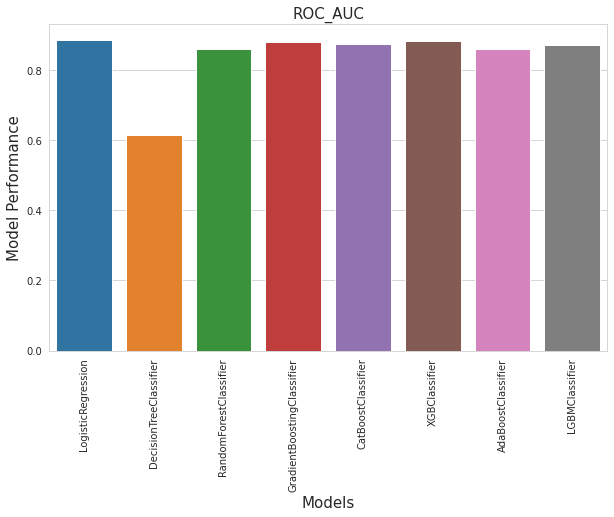

In [106]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.title('ROC_AUC', fontsize=15)
plt.show()

# 이러한 결과를 통해서 앙상블 모델 사용 시, GBM을 사용하도록 하자

# 앙상블( GBM + Optuna )

- 파라미터 참고 : [sklearn.ensemble.GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)
- [Using Optuna to Optimize XGBoost Hyperparameters](https://medium.com/optuna/using-optuna-to-optimize-xgboost-hyperparameters-63bfcdfd3407)
- [AutoML? 야 너도 만들 수 있..을걸?](https://velog.io/@lazy_learner/AutoML-%EC%95%BC-%EB%84%88%EB%8F%84-%EB%A7%8C%EB%93%A4-%EC%88%98-%EC%9E%88%EC%96%B4#hyperparameters-optimization)

In [107]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 KB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.9 MB/s eta 0:00:00


In [108]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [109]:
sampler = TPESampler(seed=42)

def objectiveGBM(trial):

  param = {
  'max_depth':trial.suggest_int('max_depth',3,10),  
  'learning_rate': trial.suggest_float('learning_rate',0.01, 0.1),
  'n_estimators':trial.suggest_int('n_estimators',100, 2000),
  }

  model = GradientBoostingClassifier(**param)
  model.fit(X_train, y_train)
  pred = model.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, pred)
  return roc_auc

In [110]:
studyGBM = optuna.create_study(direction='maximize',sampler=sampler)

# n_trials 지정
studyGBM.optimize(objectiveGBM, n_trials=100)

[I 2023-02-17 00:34:04,386] A new study created in memory with name: no-name-ee34d280-4d5b-4fc3-87ea-3022b36cc273
[I 2023-02-17 00:35:16,645] Trial 0 finished with value: 0.8670087393807276 and parameters: {'max_depth': 5, 'learning_rate': 0.09556428757689246, 'n_estimators': 1491}. Best is trial 0 with value: 0.8670087393807276.
[I 2023-02-17 00:35:39,672] Trial 1 finished with value: 0.8864982273340757 and parameters: {'max_depth': 7, 'learning_rate': 0.02404167763981929, 'n_estimators': 396}. Best is trial 1 with value: 0.8864982273340757.
[I 2023-02-17 00:36:12,003] Trial 2 finished with value: 0.8677583350712412 and parameters: {'max_depth': 3, 'learning_rate': 0.08795585311974417, 'n_estimators': 1242}. Best is trial 1 with value: 0.8864982273340757.
[I 2023-02-17 00:38:24,820] Trial 3 finished with value: 0.8773201068714906 and parameters: {'max_depth': 8, 'learning_rate': 0.011852604486622221, 'n_estimators': 1943}. Best is trial 1 with value: 0.8864982273340757.
[I 2023-02-17 

In [111]:
print('study.best_params:', studyGBM.best_trial.value)
print('Number of finished trials:', len(studyGBM.trials))
print('Best trial:', studyGBM.best_trial.params)

study.best_params: 0.8978484046006682
Number of finished trials: 100
Best trial: {'max_depth': 4, 'learning_rate': 0.026405042068903373, 'n_estimators': 100}


In [112]:
# 하이퍼파라미터별 중요도를 확인할 수 있는 그래프
optuna.visualization.plot_param_importances(studyGBM)

In [113]:
# 하이퍼파라미터 최적화 과정을 확인
optuna.visualization.plot_optimization_history(studyGBM)

In [114]:
X.shape, X_test_df.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape

((15553, 20),
 (10204, 20),
 (15553,),
 (12442, 20),
 (12442,),
 (3111, 20),
 (3111,))

In [115]:
final_gbm_model = GradientBoostingClassifier(**studyGBM.best_params)
final_gbm_model.fit(X, y)
sub_xgb_pred = final_gbm_model.predict_proba(X_test_df)[:,1]
sub_xgb_pred 

array([0.05193867, 0.21133151, 0.00903817, ..., 0.00903817, 0.00922069,
       0.00903817])

In [116]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()

preds = minmax.fit_transform(sub_xgb_pred.reshape(-1, 1))

In [117]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': preds.reshape(-1, )
})
submission.head()

,id,stroke
0,15304,0.053189
1,15305,0.250808
2,15306,0.000000
3,15307,0.039250
4,15308,0.000356


In [118]:
submission.to_csv('submission_gbm.csv', index=False )